In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import load_img
import os
from tensorflow.keras.callbacks import *
import pandas as pd
import copy 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR_DATA = "./train/data/"
TRAIN_DIR_LABEL = "./train/label/"
VAL_DIR_DATA = "./test/data/"
VAL_DIR_LABEL = "./test/label/"

MEMO_DIR = "./memo/"

In [3]:
def get_data(data_dir):
    data_files = os.listdir(data_dir)
    data = []
    label = []
    for dfile in data_files:
        data.append(np.load(TRAIN_DIR_DATA + dfile))
        label.append(np.load(TRAIN_DIR_LABEL + dfile.split(".")[0] + " label.npy"))
    return data,label
            
# data,label = get_data(TRAIN_DIR_DATA)

In [4]:
def pre_process(data,label):
    files_pos = []
    files_fingers = []
    for l in label: 
        grid_pos = []
        beat_fingers = []
        for j in range(len(l)):
            pos = np.array(np.where(l[j]>0)).transpose()
            grid_pos.append(pos)
            beat_fingers.append([l[j][i[0]][i[1]] for i in pos])
        files_pos.append(grid_pos)
        files_fingers.append(beat_fingers)
    return files_pos, files_fingers

# files_pos,files_fingers = pre_process(data,label)

# EMISSION

In [5]:
def get_eprobs(val,finger,fingers):
    return val/fingers.count(finger)


def get_emission(files_pos,files_fingers):
    pos_int = None
    fingers_int = None
    for i in range(len(files_pos)): 
        if i == 0: 
            pos_int = files_pos[i]
            fingers_int = files_fingers[i]
        else: 
            pos_int += files_pos[i] 
            fingers_int += files_fingers[i]

    pos = []
    list(map(pos.extend, pos_int))
    fingers = [] 
    list(map(fingers.extend, fingers_int))
    pos = [tuple(i) for i in pos]

    emission_df = pd.DataFrame()
    emission_df["pos"] = pos
    emission_df["fingers"] = fingers

    df = emission_df.groupby(['pos', 'fingers']).size().reset_index()
    df.columns = ["pos","fingers","count"] 


    df["e"] = df.apply(lambda x: get_eprobs(x['count'],x['fingers'],fingers),axis=1)
    df = df.drop(columns = ["count"])
    
    return df

# e_df = get_emission(files_pos,files_fingers)
# e_df

# TRANSMISSION

In [6]:
def get_tprobs(val,finger,new_prev_finger):
    return val/np.count_nonzero(new_prev_finger.flatten() == 1)

def get_transition(files_pos,files_fingers):
    post_file_finger = []
    transmission_df = pd.DataFrame()

    prev_finger = []
    curr_finger = []
    for i in range(len(files_pos)): 
        prev_finger_temp = files_fingers[i][0:len(files_fingers[i])-1]
        curr_finger_temp = files_fingers[i][1:len(files_fingers[i])]
        prev_finger += prev_finger_temp
        curr_finger += curr_finger_temp
        
    prev_finger = [tuple(sorted(i)) for i in prev_finger]
    curr_finger = [tuple(sorted(i)) for i in curr_finger]

    new_prev_finger = []
    new_curr_finger = []

    for tuplei,tuplej in zip(prev_finger,curr_finger): 
        for val1 in tuplei: 
            for val2 in tuplej:
                new_prev_finger.append(val1)
                new_curr_finger.append(val2)

    new_prev_finger = np.array(new_prev_finger)
    new_curr_finger = np.array(new_curr_finger)

    transmission_df["prev_finger"] = new_prev_finger
    transmission_df["curr_finger"] = new_curr_finger
    transmission_df
    df1 = transmission_df.groupby(['prev_finger', 'curr_finger']).size().reset_index()
    df1 = df1[df1["prev_finger"] != () ]
    df1 = df1[df1["curr_finger"] != () ]
    # df1

    df1.columns = ["prev_finger", "curr_finger", "count"]
    df1
    df1["t"] = df1.apply(lambda x: get_tprobs(x['count'],x['prev_finger'],new_prev_finger),axis=1)
    df1 = df1.drop(columns = ["count"])
    return df1

# t_df = get_transition(files_pos,files_fingers)
# t_df

# Convert emission to table

In [7]:
def emission_to_table(df):
    row_e = df["pos"].values
    column_e = df["fingers"].values
    y_e = list(np.unique(row_e))
    x_e = list(np.unique(column_e))
    # Init empty array 
    e_array = np.zeros((len(y_e),len(x_e)))

    # Fill up 
    for i in range(len(df)):
        row_idx = y_e.index(df.iloc[i]["pos"])
        column_idx = x_e.index(df.iloc[i]["fingers"])
        e_array[row_idx][column_idx] = df.iloc[i]["e"]

    return e_array, y_e, x_e

# e_array, y_e, x_e = emission_to_table(e_df)
# e_array

# Convert transition to table

In [8]:
def transition_to_table(df1): 
    row_t = df1["prev_finger"].values
    column_t = df1["curr_finger"].values
    y_t = list(np.unique(row_t))
    x_t = list(np.unique(column_t))

    # Init empty array
    t_array = np.zeros((len(y_t),len(x_t)))

    # Fill up 
    for i in range(len(df1)):
        row_idx = y_t.index(df1.iloc[i]["prev_finger"])
        column_idx = x_t.index(df1.iloc[i]["curr_finger"])
        t_array[row_idx][column_idx] = df1.iloc[i]["t"]
    return t_array,y_t,x_t
    
# t_array,y_t,x_t = transition_to_table(t_df)
# t_array

# Training

In [9]:
def reconstruct_grid(grids,fingers):
    finger_grid = np.zeros((4,4))
    for i,j in zip(grids,fingers):
        if j == None:
            finger_grid[i[0]][i[1]] = 0
        else: 
            finger_grid[i[0]][i[1]] = j
    return finger_grid
    
# reconstruct_grid(grids,chosen_fingers)

In [10]:
def train(data,label):
    files_pos,files_fingers = pre_process(data,label)
    e_df = get_emission(files_pos,files_fingers)
    t_df = get_transition(files_pos,files_fingers)
    e_array, y_e, x_e = emission_to_table(e_df)
    t_array,y_t,x_t = transition_to_table(t_df)
    return e_array, y_e, x_e, t_array, y_t, x_t
    
train_data,train_label = get_data(TRAIN_DIR_DATA)
e_array, y_e, x_e, t_array, y_t, x_t = train(train_data,train_label)

# Inference

In [11]:
# predict_one takes in grid position(s) that exist in that current beat, and previous fingers
# list to store chosen fingers this round.
# for each position: 
#     1a) if prev state is available, then predict what is the most likely fingers. 
#          choose the finger with highest probability based on grid pos and not in list 
#     1b) else (prev state not available/no such transition)
#          choose finger with highest probability based on grid pos and not in list
# return chosen fingers in order.

def predict_one(grid_pos_list, prev_finger, e_array, y_e, x_e, t_array, y_t, x_t):
    chosen_fingers = []
    y_e = np.array(y_e)
    x_e = np.array(x_e)
    y_t = np.array(y_t)
    x_t = np.array(x_t)
    
    for grid_pos in grid_pos_list: 
        chosen_finger = None
        scores = [1 for i in range(10)]

        if prev_finger != None:
            # Get transition probabilities
            for finger in prev_finger: 
                for i in range(10):
                    try: 
                        y = np.where(np.array(y_t) == finger)[0][0]
                        x = np.where(np.array(x_t) == i+1)[0][0]
                        t = t_array[y][x]
                        scores[i] *= t
                    except: 
#                         print("No transition found")
                        scores[i] *= 0.001
        # Get emission probabilities
        for i in range(10):
            try: 
                y = np.where(np.array(y_e) == grid_pos)[0][0]
                x = np.where(np.array(x_t) == i+1)[0][0]
                e = e_array[y][x]
                scores[i] *= e
            except: 
#                 print("No emission")
                scores[i] *= 0.001
#         print(scores)
        scores_copy = sorted(copy.deepcopy(scores))
        idxes = [scores.index(i)+1 for i in scores_copy]
        for chosen in idxes:
            if chosen not in chosen_fingers: 
                chosen_finger = copy.deepcopy(chosen) 
        chosen_fingers.append(chosen_finger)
    return chosen_fingers

# import time 

# start = time.time()
# grids = [(1,0),(0,1)]
# chosen_fingers = predict_one([(1,0),(0,1)],None,e_array, y_e, x_e, t_array, y_t, x_t)
# end = time.time() 
# print(end-start)
# print(chosen_fingers)




In [12]:
# predict, predicts sequence. take in a list of beats - grid positions. 
# list to store chosen fingers
# init prev_fingers = 
# for each beat: 
#    fingers = predict_one(beat, prev_fingers) 
#    prev_fingers = copy of fingers
#    append fingers to list of chosen fingers 
# reconstruct sequence into 2d array 
# return sequence 

def predict(grids_sequence,e_array, y_e, x_e, t_array, y_t, x_t): 
    prev_fingers = None
    finger_sequence = []
    
    for beat in tqdm(grids_sequence):
        curr_fingers = predict_one(beat,prev_fingers,e_array, y_e, x_e, t_array, y_t, x_t)
        prev_fingers = copy.deepcopy(curr_fingers)
        finger_sequence.append(curr_fingers)
    
    finger_array = []
    for pos,finger in zip(grids_sequence, finger_sequence):
        finger_array.append(reconstruct_grid(pos,finger))
    
    return finger_array

In [13]:
def deconstruct_grid(grid_arrays):
    grid_pos = []
    for l in range(len(grid_arrays)): 
        pos = np.array(np.where(grid_arrays[l]>0)).transpose()
    #     print(pos)
    #     print(l)
        grid_pos.append(pos)
    return grid_pos

In [14]:
# Test from directory 

def test(TEST_DIR_DATA,e_array, y_e, x_e, t_array, y_t, x_t): 
    test_data,test_label = get_data(TEST_DIR_DATA)
    finger_arrays = []
    for test in test_data: 
        input_array = np.array(deconstruct_grid(data[0]))
        finger_array = predict(input_array,e_array, y_e, x_e, t_array, y_t, x_t)
        finger_arrays.append(finger_array)
    return finger_arrays

In [15]:
# finger_array is the predicted output
test = np.array(deconstruct_grid(train_data[0]))
finger_array = predict(test,e_array, y_e, x_e, t_array, y_t, x_t)
finger_array = np.array(finger_array)

/home/eternal/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
100%|██████████| 706/706 [00:00<00:00, 3451.77it/s]


In [16]:
# Custom input test
a = np.array([[[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 0]],
              [[0, 0, 1, 0],
               [1, 1, 1, 1],
               [0, 0, 1, 0],
               [0, 0, 1, 0]]])

b = np.array([[[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 6, 0],
               [0, 0, 0, 0]],
              [[0, 0, 8, 0],
               [3, 4, 7, 9],
               [0, 0, 6, 0],
               [0, 0, 5, 0]]])

test1= np.array(deconstruct_grid(a[:1]))
test2= np.array(deconstruct_grid(a[1:]))


finger_array1 = predict(test1,e_array, y_e, x_e, t_array, y_t, x_t)
finger_array1 = np.array(finger_array1)

finger_array2 = predict(test2,e_array, y_e, x_e, t_array, y_t, x_t)
finger_array2 = np.array(finger_array2)


print(finger_array1.astype(int)[0])
print("\n")
print(finger_array2.astype(int)[0])

100%|██████████| 1/1 [00:00<00:00, 856.68it/s]

[[0 0 0 0]
 [0 0 0 0]
 [0 0 8 0]
 [0 0 0 0]]


[[ 0  0  1  0]
 [ 4  3  8 10]
 [ 0  0  7  0]
 [ 0  0  9  0]]


In [17]:
# Conversion into json for Unity visualisation
from jubeatnet.core import PatternFingering, Pattern, JubeatChartFingering
from jubeatnet.parsers import CosmosMemoParser
from pathlib import Path


data_files = os.listdir(TRAIN_DIR_DATA)
memo = Path(MEMO_DIR + data_files[0].lower().replace(" ","_").replace("npy","txt"))
parser = CosmosMemoParser()
chart = parser.parse(memo)
sequence = JubeatChartFingering(chart,"red zone",None)

for idx in range(len(finger_array)):
    pattern = chart.sequence[idx][1]
    index = chart.sequence[idx][0]
    fingering = PatternFingering(pattern)
    fingering.set_finger_matrix(finger_array[idx])
    sequence.set_pattern_fingering(idx,fingering)
    
jsonstring = sequence.to_json_string()
with open("red_zone.json","w") as f:
    f.write(jsonstring)


In [18]:
# Calculates meanIOU

from sklearn.metrics import jaccard_score
true = train_label[0].flatten().astype(float)
pred = finger_array.flatten()
jaccard_score(true,pred,average='macro')

0.21354445346972772

In [19]:
# Calculates traversal cost
def get_traversal_cost(pred):
    centroids = []
    values = []
    # Find centroids and save values for each finger
    for i in range(1,11):
        value = np.array([])
        for j in pred: 
            pos = np.array(np.where(j == i)).transpose()
            if len(value)==0:
                value = pos
            else:                 
                value = np.concatenate((value,pos))
        if len(value) >0:
            value = np.array(value)
            x_coords = [p[0] for p in value]
            y_coords = [p[1] for p in value]
            _len = len(x_coords)
            centroid_x = sum(x_coords)/_len
            centroid_y = sum(y_coords)/_len
            centroids.append([centroid_x,centroid_y])
            values.append([x_coords,y_coords])
    size = len(values[0])
    cost = 0
    for centroid,value in zip(centroids,values):
        x_coords = value[0]
        y_coords = value[1]
        x = sum([(i-centroid[0])**2 for i in x_coords])
        y = sum([(j-centroid[1])**2 for j in y_coords])
        avg = (x+y)/size
        cost += avg
    return cost

get_traversal_cost(finger_array)

778.7830741370616

In [20]:
# Obtain fingering predictions and labels for beat i
def getbeatmap(pred,label,i):
    prediction = np.argmax(pred[i], axis=-1)
    labels = label[i].reshape(label[i].shape[0],label[i].shape[1])
    return (prediction, labels)
    
    
def F1Score(pred,label):
    predictedfingercount = 0
    goldlabelfingercount = 0
    correctlypredictedcount = 0
    wronglypredictedcount = 0
    for i in range(label.shape[0]):
        prediction, labels = getbeatmap(pred,label,i)
        for row in range(4):
            for col in range(4):
                if labels[row][col] == 0:
                    if prediction[row][col] != 0:
                        predictedfingercount+=1
                        wronglypredictedcount+=1
                elif labels[row][col] == prediction[row][col]:
                    predictedfingercount+=1
                    goldlabelfingercount+=1
                    correctlypredictedcount+=1
                else:
                    if prediction[row][col] != 0:
                        predictedfingercount+=1
                        goldlabelfingercount+=1
                        wronglypredictedcount+=1
                    else:
                        goldlabelfingercount+=1
                        
                    
    precision =  correctlypredictedcount/predictedfingercount
    recall = correctlypredictedcount/goldlabelfingercount
    f1score = 2/((1/precision)+(1/recall))
    return f1score, precision, recall
                
def leftrightscorePred(data):
    lefthandcount = 0
    righthandcount = 0
    for i in range(data.shape[0]):
        #print(data.shape[0])
        beatmapdata = np.argmax(data[i], axis=-1)
        for row in range(4):
            for col in range(4):
                if beatmapdata[row][col] >= 1 and beatmapdata[row][col] <= 5:
                    lefthandcount += 1
                elif beatmapdata[row][col] >= 6 and beatmapdata[row][col] <= 10:
                    righthandcount += 1
    return (lefthandcount, righthandcount)


def leftrightscoreLabel(label):
    lefthandcount = 0
    righthandcount = 0
    for i in range(label.shape[0]):
        beatmapdata = label[i].reshape(label[i].shape[0],label[i].shape[1])
        for row in range(4):
            for col in range(4):
                if beatmapdata[row][col] >= 1 and beatmapdata[row][col] <= 5:
                    lefthandcount += 1
                elif beatmapdata[row][col] >= 6 and beatmapdata[row][col] <= 10:
                    righthandcount += 1
    return (lefthandcount, righthandcount)

def fingerCountPred(data):
    finger_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
    for i in range(data.shape[0]):
        beatmapdata = np.argmax(data[i], axis=-1)
        for row in range(4):
            for col in range(4):
                if beatmapdata[row][col] != 0:
                    finger_dict[beatmapdata[row][col]] += 1
    return finger_dict

def fingerCountLabel(label):
    finger_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0}
    for i in range(label.shape[0]):
        beatmapdata = label[i].reshape(label[i].shape[0],label[i].shape[1])
        for row in range(4):
            for col in range(4):
                if beatmapdata[row][col] != 0:
                    finger_dict[beatmapdata[row][col]] += 1
    return finger_dict
                
predictions = np.array(finger_array)
predictions = np.reshape(predictions,(predictions.shape[0],predictions.shape[1],predictions.shape[2],1))        
    
# f1score, precision, recall = F1Score(predictions,train_label[0])
finger_dict_pred = fingerCountLabel(predictions)
finger_dict_label = fingerCountLabel(train_label[0])

# print(f'F1 Score: {f1score}, Precision: {precision}, Recall: {recall}')
print(f'Finger Count for Prediction: {finger_dict_pred}')
print(f'Finger Count for Label: {finger_dict_label}')

Finger Count for Prediction: {1: 0, 2: 39, 3: 2, 4: 476, 5: 5, 6: 11, 7: 332, 8: 0, 9: 6, 10: 0}
Finger Count for Label: {1: 0, 2: 23, 3: 0, 4: 211, 5: 193, 6: 193, 7: 229, 8: 0, 9: 19, 10: 0}


In [21]:
values = {}
for i in range(1,11):
    if i not in values: 
        values[i] = np.count_nonzero(finger_array == i)
    else: 
        values[i] += np.count_nonzero(finger_array == i)
values

{1: 0, 2: 39, 3: 2, 4: 476, 5: 5, 6: 11, 7: 332, 8: 0, 9: 6, 10: 0}

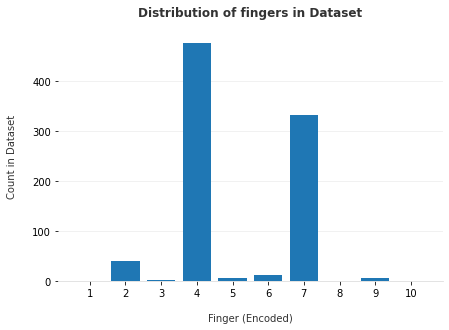

In [22]:
# Finger distribution visualization

fig, ax = plt.subplots()

fingers = [i for i in range(1,11)]

bars = ax.bar(
    x=np.arange(len(values)),
    height=list(values.values()),
    tick_label=fingers
)
plt.rc('font', family='Open Sans')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

fig.tight_layout()
ax.set_xlabel('Finger (Encoded)', labelpad=15, color='#333333')
ax.set_ylabel('Count in Dataset', labelpad=15, color='#333333')
ax.set_title('Distribution of fingers in Dataset', pad=15, color='#333333',
             weight='bold')

plt.show()

In [23]:
pievals = [sum(list(values)[:5]),sum(list(values)[5:])]
pievals

[15, 40]

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


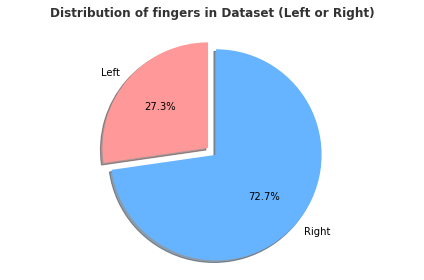

In [25]:
# Pie chart
labels = ['Left','Right']
import matplotlib.pyplot as plt

# Pie chart
explode = (0, 0.1)
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(pievals, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

ax1.set_title('Distribution of fingers in Dataset (Left or Right)', pad=15, color='#333333',
             weight='bold')
plt.tight_layout()
plt.show()